In [1]:
import os
import glob

import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

import tifffile

import napari
import zarr
import dask.array as da

In [2]:
def single_channel_pyramid(tiff_path, channel):
    tiff = tifffile.TiffFile(tiff_path)

    if 'Faas' not in tiff.pages[0].software:

        if len(tiff.series[0].levels) > 1:

            pyramid = [
                zarr.open(s[channel].aszarr()) for s in tiff.series[0].levels
            ]

            pyramid = [da.from_zarr(z) for z in pyramid]

            min_val = pyramid[0].min()
            max_val = pyramid[0].max()
            vmin, vmax = da.compute(min_val, max_val)

        else:

            img = tiff.pages[channel].asarray()

            pyramid = [img[::4**i, ::4**i] for i in range(4)]

            pyramid = [da.from_array(z) for z in pyramid]

            min_val = pyramid[0].min()
            max_val = pyramid[0].max()
            vmin, vmax = da.compute(min_val, max_val)

        return pyramid, vmin, vmax

    else:  # support legacy OME-TIFF format

        if len(tiff.series) > 1:

            pyramid = [zarr.open(s[channel].aszarr()) for s in tiff.series]

            pyramid = [da.from_zarr(z) for z in pyramid]

            min_val = pyramid[0].min()
            max_val = pyramid[0].max()
            vmin, vmax = da.compute(min_val, max_val)

        else:
            img = tiff.pages[channel].asarray()

            pyramid = [img[::4**i, ::4**i] for i in range(4)]

            pyramid = [da.from_array(z) for z in pyramid]

            min_val = pyramid[0].min()
            max_val = pyramid[0].max()
            vmin, vmax = da.compute(min_val, max_val)

        return pyramid, vmin, vmax

In [3]:
# output dir
out_dir = '../output/Fig5h-j'
if not os.path.exists(out_dir):
    os.makedirs(out_dir)

pre = pd.read_parquet('../datasets/Dataset2(CRC)/CRC-097_cylinter_raw_clustering.parquet')
post = pd.read_parquet('../datasets/Dataset2(CRC)/CRC-097_cylinter_cleaned_clustering.parquet')

pre = pre[pre['cluster_2d'] != -1]
post = post[post['cluster_2d'] != -1]

In [4]:
heatmap = pd.DataFrame(index=sorted(post['cluster_2d'].unique()))

for name, pre_group in sorted(pre.groupby(['cluster_2d'])):
    
    post_group = post[post['CellID'].isin(pre_group['CellID'])]

    clean_cluster_percents = (
        post_group.groupby(['cluster_2d']).size() / len(pre_group)
    )

    clean_cluster_pad = clean_cluster_percents.reindex(
        sorted(post['cluster_2d'].unique())).fillna(0)

    heatmap[name[0]] = clean_cluster_pad

/Users/greg/venvs/cylinter/lib/python3.11/site-packages/pandas/core/internals/blocks.py:393: RuntimeWarning: invalid value encountered in log
  result = func(self.values, **kwargs)


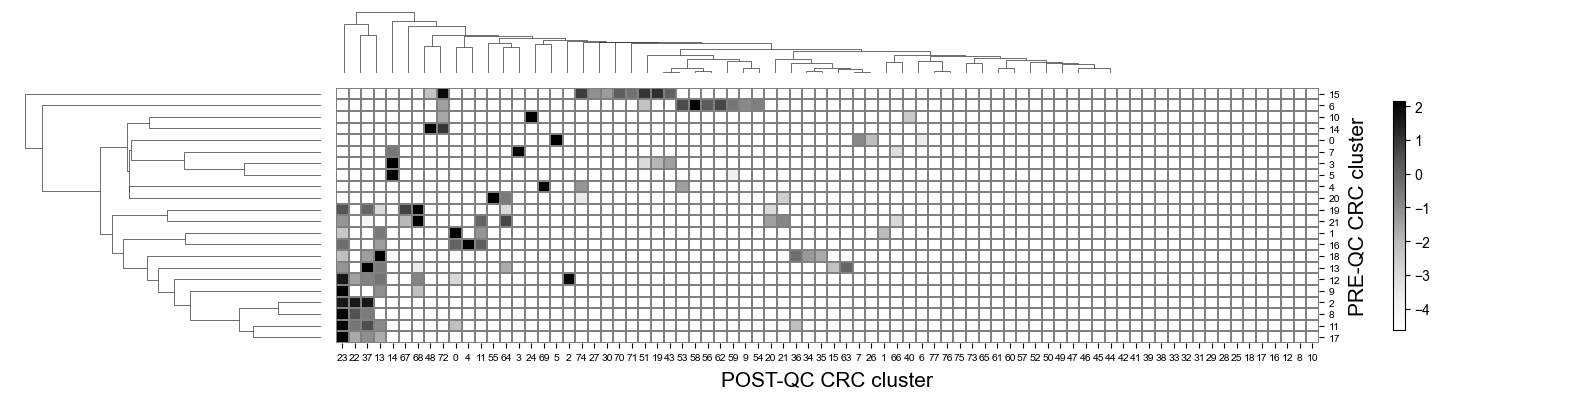

In [5]:
# z-scores
heatmap = (heatmap - heatmap.mean()) / heatmap.std()

plt.rcParams['font.family'] = 'Arial'

# NO HEATMAP CLUSTERING
# fig, ax = plt.subplots(figsize=(16, 4.1))
# g = sns.heatmap(
#     np.log(heatmap.T), xticklabels=1, yticklabels=1, cmap='Greys', square=False,
#     linewidths=0.3, linecolor='grey', cbar_kws={'shrink': 0.9, 'pad':0.01}, ax=ax)
# cbar = g.collections[0].colorbar
# cbar.set_label('Log(z-score)', fontsize=15)
# g.set_xlabel('POST-QC CRC cluster', fontsize=15, labelpad=6.0)
# g.set_ylabel('PRE-QC CRC cluster', fontsize=15, labelpad=6.0)
# g.set_xticklabels(g.get_xmajorticklabels(), fontsize=7.5, rotation=0)
# g.set_yticklabels(g.get_ymajorticklabels(), fontsize=7.5)

# HEATMAP CLUSTERING
res = np.log(heatmap.T)
clustermap_input = res.fillna(res.min().min())
g = sns.clustermap(
    clustermap_input, xticklabels=1, yticklabels=1, cmap='Greys',linewidths=0.3, linecolor='grey', 
    figsize=(16, 4.1)
)
g.ax_heatmap.collections[0].colorbar.remove()
cbar = plt.colorbar(g.ax_heatmap.collections[0], ax=g.ax_heatmap, shrink=0.9, pad=0.06)
g.ax_heatmap.set_xlabel('POST-QC CRC cluster', fontsize=15, labelpad=6.0)
g.ax_heatmap.set_ylabel('PRE-QC CRC cluster', fontsize=15, labelpad=6.0)
g.ax_heatmap.set_xticklabels(g.ax_heatmap.get_xmajorticklabels(), fontsize=7.5, rotation=0)
g.ax_heatmap.set_yticklabels(g.ax_heatmap.get_ymajorticklabels(), fontsize=7.5)

plt.tight_layout()
plt.savefig(os.path.join(out_dir, 'pre-CRC_by_post_CRC.pdf'))
plt.show()
plt.close('all')

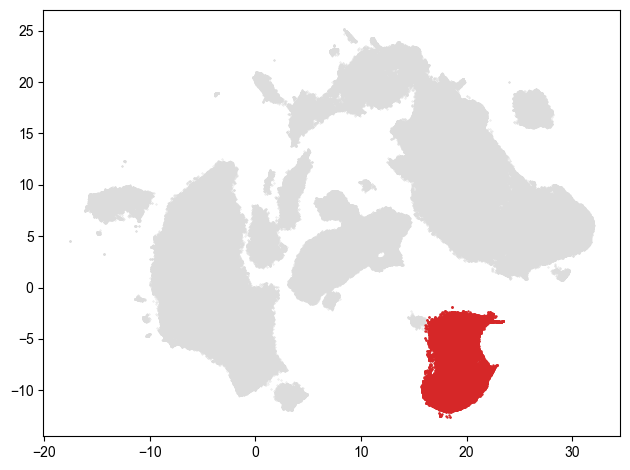

In [6]:
plt.scatter(pre['emb1'], pre['emb2'], s=0.1, c='gainsboro')
plt.scatter(
    pre['emb1'][pre['cluster_2d'] == 6], pre['emb2'][pre['cluster_2d'] == 6],
    s=0.5, c='tab:red'
)
plt.tight_layout()
plt.savefig(os.path.join(out_dir, 'UMAP1.png'), dpi=800)
plt.show()
plt.close('all')

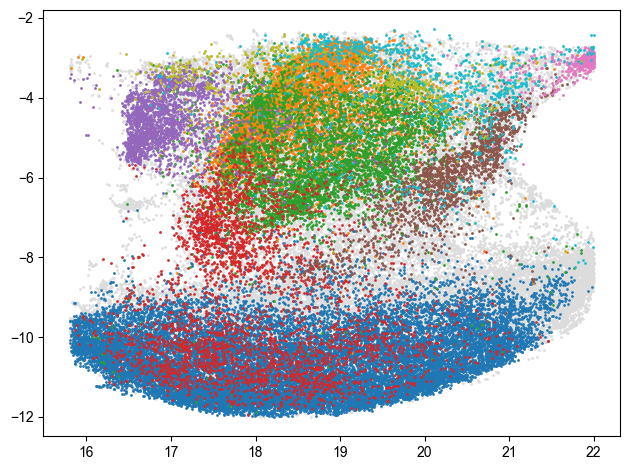

In [7]:
pre = pre[(pre['emb1'] > 15.8) & (pre['emb1'] < 22) & (pre['emb2'] < -2) & (pre['emb2'] > -12)]

plt.scatter(pre['emb1'], pre['emb2'], s=0.9, c='gainsboro')

post_cluster9 = post[post['cluster_2d'] == 9]
post_cluster51 = post[post['cluster_2d'] == 51]
post_cluster53 = post[post['cluster_2d'] == 53]
post_cluster54 = post[post['cluster_2d'] == 54]
post_cluster56 = post[post['cluster_2d'] == 56]
post_cluster58 = post[post['cluster_2d'] == 58]
post_cluster59 = post[post['cluster_2d'] == 59]
post_cluster62 = post[post['cluster_2d'] == 62]
post_cluster72 = post[post['cluster_2d'] == 72]

plt.scatter(
    pre['emb1'][pre['CellID'].isin(post_cluster58['CellID'])],
    pre['emb2'][pre['CellID'].isin(post_cluster58['CellID'])],
    s=0.9, c='tab:blue'
)
plt.scatter(
    pre['emb1'][pre['CellID'].isin(post_cluster62['CellID'])],
    pre['emb2'][pre['CellID'].isin(post_cluster62['CellID'])],
    s=0.9, c='tab:orange'
)
plt.scatter(
    pre['emb1'][pre['CellID'].isin(post_cluster53['CellID'])],
    pre['emb2'][pre['CellID'].isin(post_cluster53['CellID'])],
    s=0.9, c='tab:green'
)
plt.scatter(
    pre['emb1'][pre['CellID'].isin(post_cluster56['CellID'])],
    pre['emb2'][pre['CellID'].isin(post_cluster56['CellID'])],
    s=0.9, c='tab:red'
)
plt.scatter(
    pre['emb1'][pre['CellID'].isin(post_cluster59['CellID'])],
    pre['emb2'][pre['CellID'].isin(post_cluster59['CellID'])],
    s=0.9, c='tab:purple'
)
plt.scatter(
    pre['emb1'][pre['CellID'].isin(post_cluster54['CellID'])],
    pre['emb2'][pre['CellID'].isin(post_cluster54['CellID'])],
    s=0.9, c='tab:brown'
)
plt.scatter(
    pre['emb1'][pre['CellID'].isin(post_cluster9['CellID'])],
    pre['emb2'][pre['CellID'].isin(post_cluster9['CellID'])],
    s=0.9, c='tab:pink'
)
plt.scatter(
    pre['emb1'][pre['CellID'].isin(post_cluster51['CellID'])],
    pre['emb2'][pre['CellID'].isin(post_cluster51['CellID'])],
    s=0.9, c='tab:olive'
)
plt.scatter(
    pre['emb1'][pre['CellID'].isin(post_cluster72['CellID'])],
    pre['emb2'][pre['CellID'].isin(post_cluster72['CellID'])],
    s=0.9, c='tab:cyan'
)
plt.tight_layout()
plt.savefig(os.path.join(out_dir, 'UMAP2.png'), dpi=800)
plt.show()
plt.close('all')

In [10]:
# Add DNA1 channel to Napari image viewer
dna_path = '../datasets/Dataset2(CRC)/tif/WD-76845-097.ome.tif'

viewer = napari.Viewer()

dna, min, max = single_channel_pyramid(glob.glob(dna_path)[0], channel=0)
viewer.add_image(
    dna, rgb=False, blending='additive', colormap='gray', visible=True,
    opacity=1.0, name='DNA1', contrast_limits=(min, max)
)

# Add centroids of pre-QC cluster 6
centroids = pre[['Y_centroid', 'X_centroid']]
viewer.add_points(
    centroids, name='Pre-QC cluster 6', face_color='white', edge_color='white', size=80.0,
    opacity=1.0, blending='translucent', visible=False
)

# Add centroids of cells from post-QC CRC clusters in pre-QC cluster 6
color_dict = {58: '#1f77b4', 62: '#ff7f0e', 53: '#2ca02c', 56: '#d62728', 59: '#9467bd',
              51: '#bcbd22',54: '#8c564b',72: '#17becf', 9: '#e377c2' 
             }
for cluster, c in color_dict.items():
    post_cluster_ids = post['CellID'][post['cluster_2d'] == cluster]
    centroids = pre[['Y_centroid', 'X_centroid']][pre['CellID'].isin(post_cluster_ids)]
    viewer.add_points(
        centroids, name=cluster, face_color=c, edge_color=c, size=70.0,
        opacity=1.0, blending='translucent', visible=True
    )

# Run Napari image viewer
viewer.scale_bar.visible = True
viewer.scale_bar.unit = 'um'

napari.run()